## Conversion Rate

### Goal


Optimizing conversion rate is likely the most common work of a data scientist, and rightfully so. The data revolution has a lot to do with the fact that now we are able to collect all sorts of data about people who buy something on our site as well as people who don’t. This gives us a tremendous opportunity to understand what’s working well (and potentially scale it even further) and what’s not working well (and fix it).

The goal of this challenge is to build a model that predicts conversion rate and, based on the model, come up with ideas to improve it.

### Challenge Description


We have data about all users who hit our site: whether they converted or not as well as some of their characteristics such as their country, the marketing channel, their age, whether they are repeat users and the number of pages visited during that session (as a proxy for site activity/time spent on site).

Your project is to:

- Predict conversion rate

- Come up with recommendations for the product team and the marketing team to improve conversion rate



[Data Exploration](#explor)    

- [Remove Outliers](#remove)
- [Visualization](#vis)
- [Dummy Variables](#dummy)

[Models](#models)    

- [Logistic Regression](#lr)
- [Random Forests](#rf)
- [Random Forests Dropping total_pages_visited](#most)
- [Partial Dependence Graph](#partial)
- [Visualize Decision Trees](#vis)

[Conclusion](#conclusion)

In [1]:
import pandas
import numpy as np
import seaborn as sns
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.inspection import partial_dependence,plot_partial_dependence
pandas.set_option('display.max_columns', 10)
pandas.set_option('display.width', 350)

%matplotlib inline

###  <a id = "explor">Data Exploration <a/>

In [2]:
#load data  
data=pandas.read_csv("conversion_project.csv")

In [3]:
#display data
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


- country : user country based on the IP address

- age : user age. Self-reported at sign-up step

- new_user : whether the user created the account during this session or had already an account and simply came back to the site

- source : marketing channel source
    - Ads: came to the site by clicking on an advertisement
    - Seo: came to the site by clicking on search results
    - Direct: came to the site by directly typing the URL on the browser 

- total_pages_visited: number of total pages visited during the session. This can be seen as a proxy for time spent on site and engagement

- converted: this is our label. 1 means they converted within the session, 0 means they left without buying anything. The company goal is to increase conversion rate: # conversions / total sessions

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              316200 non-null  object
 1   age                  316200 non-null  int64 
 2   new_user             316200 non-null  int64 
 3   source               316200 non-null  object
 4   total_pages_visited  316200 non-null  int64 
 5   converted            316200 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


In [5]:
data.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


In [6]:
data.groupby(['country']).size()

country
China       76602
Germany     13056
UK          48450
US         178092
dtype: int64

In [7]:
data.groupby(['source']).size()

source
Ads        88740
Direct     72420
Seo       155040
dtype: int64

In [8]:
data.groupby(['converted']).size()

converted
0    306000
1     10200
dtype: int64

In [9]:
#odd age values 111,123
print(sorted(data['age'].unique()))

[17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 77, 79, 111, 123]


#### <a id = "remove">Remove Outliers <a/>

In [10]:
data = data[data['age']<100]

#### <a id="vis"> Visualization <a/>

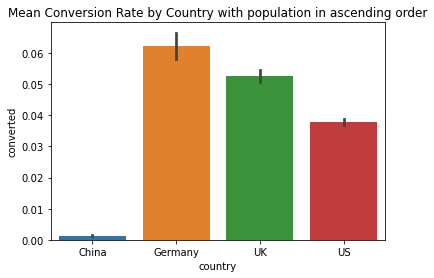

In [11]:
#Country vs Converted
country_order = data.groupby(['country']).size().index
sns.barplot(data = data, x = 'country', y = 'converted', order = country_order);
plt.title("Mean Conversion Rate by Country with population in ascending order");

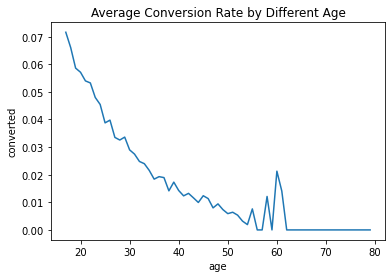

In [12]:
#Age vs Converted
data.groupby(['age'])['converted'].mean().plot();
plt.ylabel("converted");
plt.title("Average Conversion Rate by Different Age");

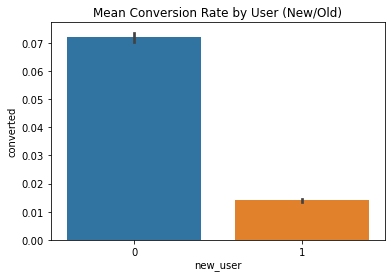

In [13]:
#New User vs Converted
sns.barplot(data = data, x = 'new_user', y = 'converted');
plt.title("Mean Conversion Rate by User (New/Old)");

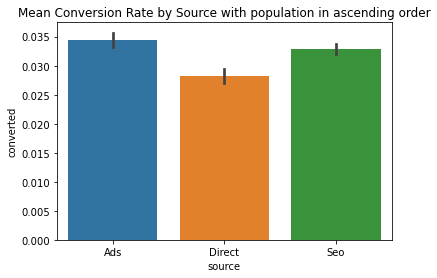

In [14]:
#Source vs Converted
source_order = data.groupby(['source']).size().index
sns.barplot(data = data, x = 'source', y = 'converted', order = source_order);
plt.title("Mean Conversion Rate by Source with population in ascending order");

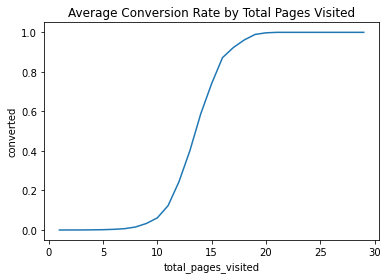

In [15]:
#Age vs Converted
data.groupby(['total_pages_visited'])['converted'].mean().plot();
plt.ylabel("converted");
plt.title("Average Conversion Rate by Total Pages Visited");

#### <a id = "dummy"> Dummy variables <a/>

In [16]:
#dummy variables for the categorical ones
data_dummy = pandas.get_dummies(data, drop_first=True)

In [17]:
data_dummy

,age,new_user,total_pages_visited,converted,country_Germany,country_UK,country_US,source_Direct,source_Seo
0,25,1,1,0,0,1,0,0,0
1,23,1,5,0,0,0,1,0,1
2,28,1,4,0,0,0,1,0,1
3,39,1,5,0,0,0,0,0,1
4,30,1,6,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...
316195,26,1,9,0,0,0,1,0,0
316196,27,1,6,0,0,0,1,1,0
316197,25,0,4,0,0,0,0,0,0
316198,22,0,4,0,0,0,1,0,1


### <a id='models'> Models <a/>

In [18]:
#test train split
train_X, test_X,train_Y,test_Y = train_test_split(data_dummy.drop('converted', axis=1),
                                                  data_dummy['converted'], test_size = 0.34)

In [19]:
print(train_X.shape, test_X.shape,train_Y.shape,test_Y.shape)

(208690, 8) (107508, 8) (208690,) (107508,)


#### <a id='lr'> Logistic Regression <a/>

In [20]:
lr = LogisticRegression(solver='liblinear', random_state=0)
lr.fit(train_X, train_Y)

LogisticRegression(random_state=0, solver='liblinear')

In [21]:
#training results
print("Logistic Regression's training accuracy is {:.4f}".format(lr.score(train_X, train_Y)),
"\n", 
"Training Confusion Matrix", 
"\n",
pandas.DataFrame(confusion_matrix(train_Y, lr.predict(train_X), labels=[0, 1])))

Logistic Regression's training accuracy is 0.9860 
 Training Confusion Matrix 
         0     1
0  201088   802
1    2118  4682


In [22]:
#testing results
print("Logistic Regression's testing accuracy is {:.4f}".format(lr.score(test_X, test_Y)),
"\n", 
"Testing Confusion Matrix"
"\n",
pandas.DataFrame(confusion_matrix(test_Y, lr.predict(test_X), labels=[0, 1])))

Logistic Regression's testing accuracy is 0.9864 
 Testing Confusion Matrix
         0     1
0  103700   410
1    1053  2345


#### <a id='rf'> Random Forests <a/>

In [23]:
rf = RandomForestClassifier(n_estimators=100, max_features=3, oob_score=True)
rf.fit(train_X, train_Y)

RandomForestClassifier(max_features=3, oob_score=True)

In [24]:
#training results
print("Random Forests' training accuracy is {:.4f}".format(rf.oob_score_),
"\n", 
"Training Confusion Matrix", 
"\n",
pandas.DataFrame(confusion_matrix(train_Y, rf.oob_decision_function_[:,1].round(), labels=[0, 1])))

Random Forests' training accuracy is 0.9839 
 Training Confusion Matrix 
         0     1
0  200786  1104
1    2253  4547


In [25]:
rf.oob_decision_function_.shape

(208690, 2)

In [26]:
#testing results
print("LRandom Forests's testing accuracy is {:.4f}".format(rf.score(test_X, test_Y)),
"\n", 
"Testing Confusion Matrix"
"\n",
pandas.DataFrame(confusion_matrix(test_Y, rf.predict(test_X), labels=[0, 1])))

LRandom Forests's testing accuracy is 0.9846 
 Testing Confusion Matrix
         0     1
0  103563   547
1    1108  2290


**Check Variance Importance** 

In [27]:
lr.coef_.shape

(1, 8)

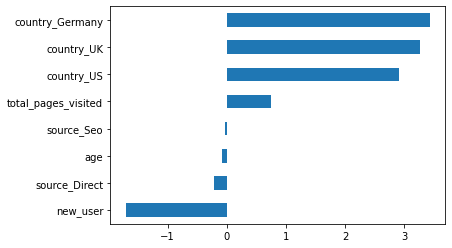

In [28]:
#logistic regression
lr_importances = pandas.Series(lr.coef_[0], index=train_X.columns)
lr_importances.sort_values().plot(kind='barh');

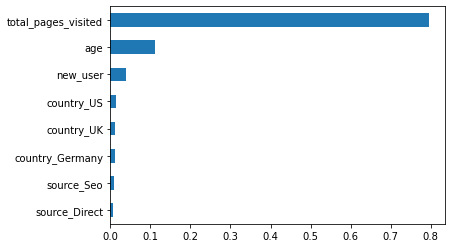

In [29]:
#randorm forests
rf_importances = pandas.Series(rf.feature_importances_, index=train_X.columns)
rf_importances.sort_values().plot(kind='barh');

#### <a id='most'>Random Forests: Drop the Most Influential Variable <a/>

Since classes are unbalanced with more unconverted and we have one major variable total_pages_visited from random forests mode, let's remove that variable, change weights, and remodel random forests

In [30]:
rf1 = RandomForestClassifier(n_estimators=100, max_features=3, oob_score=True, class_weight={0:1, 1:10})
rf1.fit(train_X.drop('total_pages_visited', axis=1), train_Y)

RandomForestClassifier(class_weight={0: 1, 1: 10}, max_features=3,
                       oob_score=True)

In [31]:
#training results
print("Random Forests' training accuracy is {:.4f}".format(rf1.oob_score_),
"\n", 
"Training Confusion Matrix", 
"\n",
pandas.DataFrame(confusion_matrix(train_Y, rf1.oob_decision_function_[:,1].round(), labels=[0, 1])))

Random Forests' training accuracy is 0.8892 
 Training Confusion Matrix 
         0      1
0  182591  19299
1    3814   2986


In [32]:
#testing results
print("LRandom Forests's testing accuracy is {:.4f}"
      .format(rf1.score(test_X.drop('total_pages_visited', axis=1), test_Y)),
"\n", 
"Testing Confusion Matrix"
"\n",
pandas.DataFrame(confusion_matrix(test_Y, rf1.predict(test_X.drop('total_pages_visited', axis=1)), labels=[0, 1])))

LRandom Forests's testing accuracy is 0.8908 
 Testing Confusion Matrix
        0     1
0  94253  9857
1   1881  1517


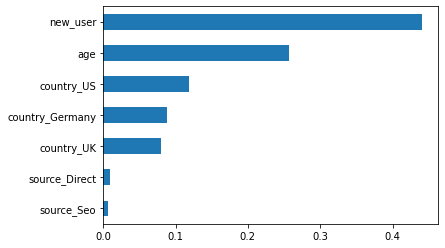

In [33]:
#randorm forests
rf1_importances = pandas.Series(rf1.feature_importances_, index=train_X.drop('total_pages_visited', axis=1).columns)
rf1_importances.sort_values().plot(kind='barh');

Now new_user becomes the most influential variable after removing total_pages_visited

#### <a id="partial"> Partial Dependence Graph<a/>

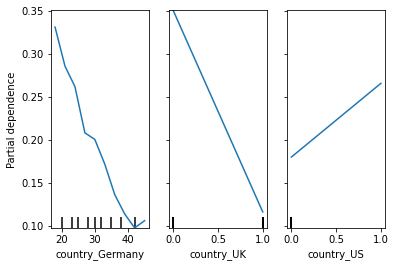

In [34]:
plot_partial_dependence(rf1,features=['country_Germany','country_UK','country_US'], # column numbers of plots we want to show
                            X=train_X.drop('total_pages_visited', axis=1),            # raw predictors data.
                            feature_names=['country_Germany','country_UK','country_US', 'converted'], # labels on graphs
                            grid_resolution=10); # number of values to plot on x axis

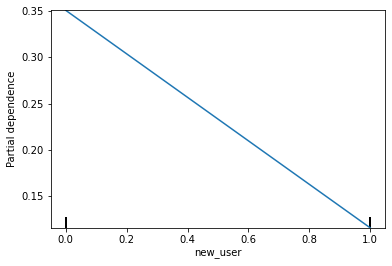

In [35]:
plot_partial_dependence(rf1,features=['new_user'], # column numbers of plots we want to show
                            X=train_X.drop('total_pages_visited', axis=1)); # number of values to plot on x axis

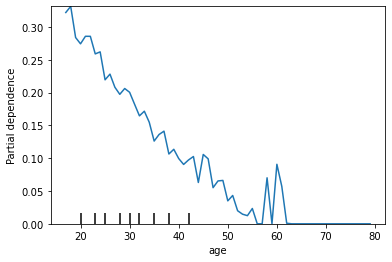

In [36]:
plot_partial_dependence(rf1,features=['age'], # column numbers of plots we want to show
                            X=train_X.drop('total_pages_visited', axis=1)); # number of values to plot on x axis

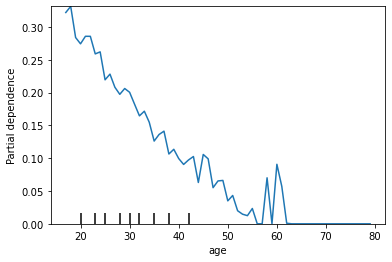

In [37]:
plot_partial_dependence(rf1,features=['age'], # column numbers of plots we want to show
                            X=train_X.drop('total_pages_visited', axis=1),method = "brute");

#### <a id='vis'> Visualize Decision Trees <a/>

Build a decision tree which matches the findings from ranfom forest

In [39]:
dt = DecisionTreeClassifier( max_depth=2,class_weight={0:1, 1:10}, min_impurity_decrease = 0.001)
dt.fit(train_X.drop('total_pages_visited', axis=1), train_Y)



DecisionTreeClassifier(class_weight={0: 1, 1: 10}, max_depth=2,
                       min_impurity_decrease=0.001)

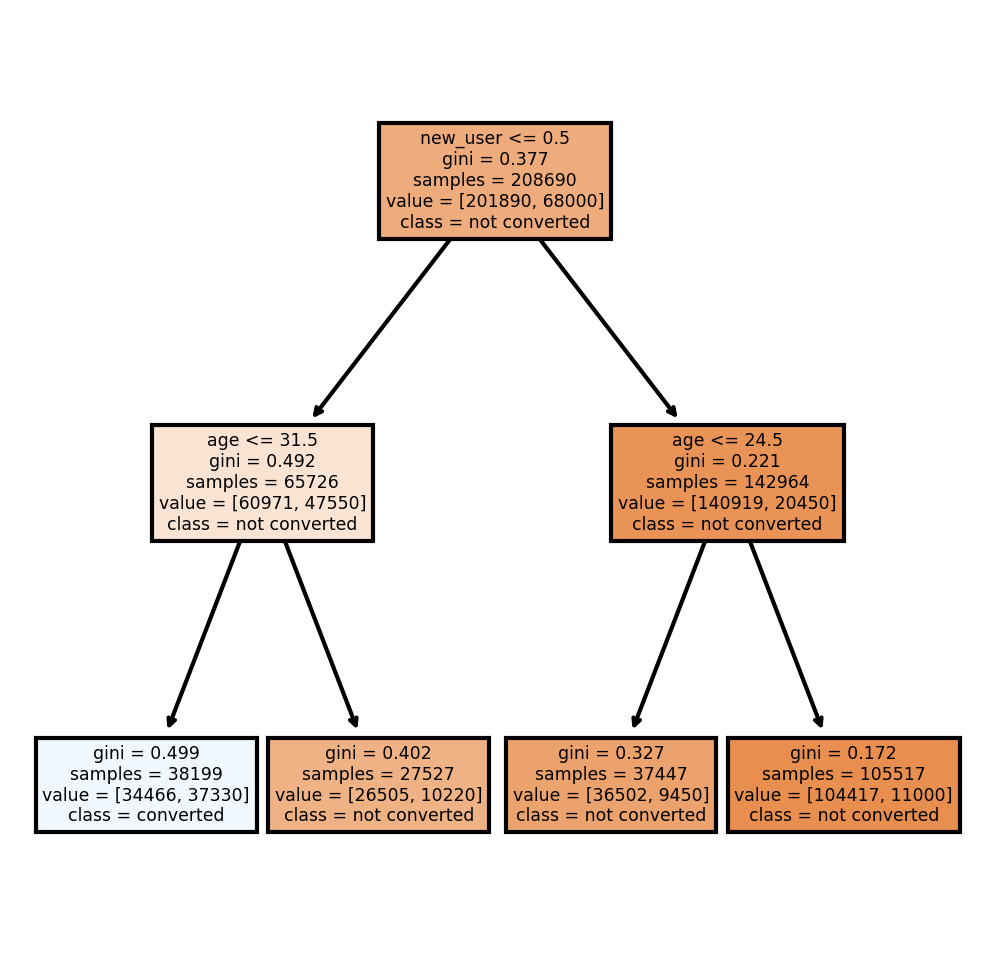

In [41]:
fn=train_X.drop('total_pages_visited', axis=1).columns
#class 0, 1
cn=['not converted','converted']
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
tree.plot_tree(dt,
               feature_names = fn, 
               class_names=cn,
               filled = True);
fig.savefig('tree_graph.png')

In general, an old account is more likely to convert, and younger users are more likely to convert

### <a id='conclusion'> Conclusion: <a/>

1. This website attracts young users. Should advertise to reach out to younger population.
2. Target Germans since they have the highest average conversion rate.
3. Old users perform well in terms of conversion rate. Should focus on them to improve retention.
4. Potential opportunity within Chinese market. Although current with the lowest conversion rate, it may be poor translation or different culture which worth investigating.